In [69]:
from typing import TypedDict, Annotated
import operator
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from langgraph.graph import StateGraph, START, END
from orgo import Computer
import os
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(model_name="gpt-4o")


In [76]:
from typing import TypedDict, Annotated
import operator

# -- 1. Define EventState schema --
class EventState(TypedDict, total=False):
    title: str
    date: str
    time: str
    duration: str
    participants: Annotated[list[str], operator.add]
    location: str
    description: str


In [72]:
def prompt_details(state: EventState) -> EventState:
    """
    Prompt for any missing event fields, parse 'key: value' responses.
    """
    missing = [k for k, v in state.items() if v is None]
    question = (
        "Please provide the following event details: "
        + ", ".join(missing)
        + "."
    )
    # Use ChatOpenAI.generate with HumanMessage
    result = llm.generate([[HumanMessage(content=question)]])
    # Extract the text from the first generation
    resp = result.generations[0][0].text
    for line in resp.splitlines():
        if ':' in line:
            key, val = line.split(':', 1)
            state[key.strip()] = val.strip()
    return state


def check_complete(state: EventState) -> dict[str, bool]:
    """
    Check if required fields are all present.
    """
    required = ('title', 'date', 'time', 'duration')
    return all(state.get(f) for f in required)


def create_event(state: EventState) -> dict[str, str]:
    """
    Automate Google Calendar via Orgo's Computer.
    """
    comp = Computer()
    comp.start()
    # Open browser and navigate to Google Calendar
    comp.prompt("If not already open on google calendar, open browser and go to https://calendar.google.com")
    comp.prompt("Click the Create button to start a new event")
    # Fill fields
    comp.prompt(f"Set event title to {state['title']}")
    comp.prompt(f"Set event date to {state['date']}")
    comp.prompt(f"Set event start time to {state['time']}")
    comp.prompt(f"Set event duration to {state['duration']}")
    if participants := state.get('participants'):
        comp.prompt(f"Add guests {', '.join(participants)}")
    if location := state.get('location'):
        comp.prompt(f"Set location to {location}")
    if desc := state.get('description'):
        comp.prompt(f"Set description to {desc}")
    comp.prompt("Save the event")
    comp.stop()
    return {"status": "Event created on Google Calendar"}


In [73]:
# -- 4. Build StateGraph --
graph = StateGraph(EventState)

graph.add_node("prompt_details", prompt_details)
graph.add_node("create_event", create_event)

graph.add_edge(START, "prompt_details")

graph.add_edge("prompt_details", "create_event")
graph.add_conditional_edges(
    "prompt_details",
    check_complete,
    path_map={True: "create_event", False: "prompt_details"}
)
graph.add_edge("create_event", END)

compiled = graph.compile()

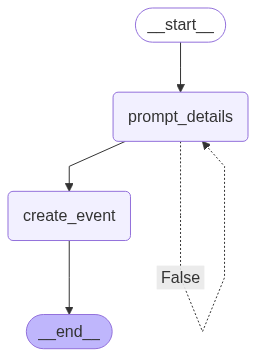

In [74]:
from IPython.display import Image, display

display(Image(compiled.get_graph().draw_mermaid_png()))

In [75]:

initial: EventState = {}
result = compiled.invoke(initial)
print(result)

Exception: API error: 404 - Project not found